In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score 
from sklearn.metrics import r2_score, mean_absolute_error 


import statsmodels.api as sm

# Introduction

As earth scientists, we seek to undertand the physical, chemical, and biological processes that shape the natural world. However, earth science data often varies temporally, varies spatially, and contains lots of noise due to both instrumentation and the stochasicity of natural phenomenon. 

With increasing climate instability, it is of utmost importance to understand sedimentation in different environmental regimes and to extract predictive models from recorded data. Here, I focus on marsh sedimentation recorded as "vertical accretion rate (mm/yr)" which is the process that builds our coastlines and combats land loss due to relative sea level rise. The saying is that coastal Louisiana loses about an american football field worth of land each hour, and although that has slowed in recent years, it makes constraining the drivers of vertical accretion crucial for management and protection efforts. 
 
The data was collected from both the Coastal Reference Monitoring System (CRMS) and the Coastal Information Management System (CIMS) websites. Additionally, I have added my own remote sensing and GIS variables derived from Google Earth Engine (NDVI and total suspended sediment estimates) and ArcMap (distance to water and rivers). Data downloads and descriptions are availible in the links below: 

CRMS: https://www.lacoast.gov/chart/Charting.aspx?laf=crms&tab=2 
CIMS: https://cims.coastal.louisiana.gov/monitoring-data/ 

Due to the focus of this tutorial being one of ML implementation rather than one of exploratory analysis and data preprocessing, I have done the justice of precompiling the dataset by excluding irrelevant variables, removing outliers, log transforming the distance variabels (which exhibited logarithmic distributions). However, one should note that the preprocessing part of any ML workflow is one of the most important parts of any project. 

In [5]:
# read in dataset
df = pd.read_csv(r"/Users/etiennechenevert/Documents/fall2022/ESIP_tutorial/ESIP_dataset2.csv", 
                encoding="unicode_escape")
print(df.columns) # lets see what variables we are working with

Index(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed',
       'Tide Amp (ft)', 'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)',
       'Avg. Flood Depth (ft)', '90th Percentile Flood Depth (ft)',
       '10th Percentile Flood Depth (ft)', 'Std. Deviation Flood Depth (ft)',
       'Log Distance to Water (km)', 'Log Distance to River (km)', 'Community',
       'Longitude', 'Latitude', 'Organic Matter (%)', 'Bulk Density (g/cm3)'],
      dtype='object')


In [6]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns) )

Number of samples in dataset:  208
Number of features in the dataset:  21


In [7]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Longitude', 'Latitude', 'Bulk Density (g/cm3)', 'Organic Matter (%)'
], axis=1)
# rename the variables to make sure it is clear what they represent and looks clean
df = df.rename(columns={
    'Tide_Amp (ft)': 'Tidal Amplitude (ft)',
    'tss_med_mg/l': 'TSS (mg/l)',
    'avg_flooding (ft)': 'Average Flood Depth (ft)',
    'Avg. Time Flooded (%)': 'Average Time Flooded (%)',
    'Flood Freq (Floods/yr)': 'Flood Frequency (Floods/yr)'
})

I removed the variables: longitude, latitude, bulk density, and organic matter (%) because they do not provide us with an assocaited transport process such as flooding, biomass production, etc. Latitude and longitude are not physical variables but rather are geographic descriptions of where sites are. While bulk density and organic matter (%) are descriptions of the soil that has already been deposited, rather than how it might have been deposited.

In [8]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; excluding the categorical Site and Maarsh community variables
print(feature_ls) # looks good; great!

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed', 'Tide Amp (ft)', 'Average Time Flooded (%)', 'Flood Frequency (Floods/yr)', 'Avg. Flood Depth (ft)', '90th Percentile Flood Depth (ft)', '10th Percentile Flood Depth (ft)', 'Std. Deviation Flood Depth (ft)', 'Log Distance to Water (km)', 'Log Distance to River (km)']


## Data Description

The remaining variables that will be used in the analysis are: 
* Accretion Rate (mm/yr): The amount of sediment deposited above a datum,
* Soil Porewater Salinity (ppt): The ppt measured from a syringe inserted into the soil, 
* Average Height Dominant (cm): Survey measurement of the average hiehgt of the dominant vegetation species, 
* NDVI: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7, 
* TSS (mg/l): Estimate of Total Suspended Sediment (TSS) from MODIS, 
* Windspeed: Reanalysis data from the Global Wind Atlas availible from Google Earth Engine (GEE), 
* Tidal Amplitude (ft): The average daily difference between the highest recorded hourly waterlevel and lowest,
* Average Time Flooded (%): The percentage of time in which the waterlevel exceeds the elevaation of the marsh,
* Flood Frequency (Floods/yr): The number of times that the waterlevel exceeds the elevation of the marsh, 
* Average Flood Depth (ft): The average waterlevel when the waterlevel is higher than the marsh elevation, 
* 90th Percentile Flood Depth (ft): The 90th percentile of the timeseries distribution of average flood depth, 
* 10th Percentile Flood Depth (ft): The 10th percentile of the timeseries distribution of average flood depth, 
* Std. Deviation Flood Depth (ft): The standard deviation of the timeseries distribution of average flood depth, 
* Log Distance to Water (km): The log of the distance to the nearest water pixel (90% recurrence), 
* Log Distance to River (km): The log of the distance to the nearest GRWL river vector taken from GEE, 
* Community: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

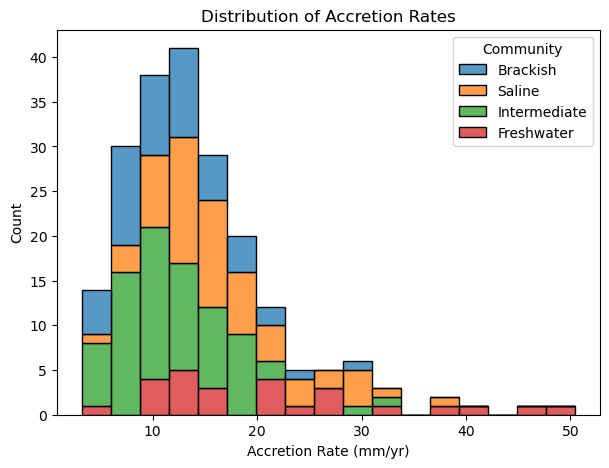

In [9]:
# Lets visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [10]:
# lets define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [11]:
target.describe()

count    208.000000
mean      14.544686
std        7.679710
min        3.208008
25%        9.684788
50%       12.701547
75%       18.200853
max       50.425133
Name: Accretion Rate (mm/yr), dtype: float64

In [12]:
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),Windspeed,Tide Amp (ft),Average Time Flooded (%),Flood Frequency (Floods/yr),Avg. Flood Depth (ft),90th Percentile Flood Depth (ft),10th Percentile Flood Depth (ft),Std. Deviation Flood Depth (ft),Log Distance to Water (km),Log Distance to River (km)
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,7.488726,109.645312,0.345306,33.776169,6.714686,0.377559,42.729742,163.631107,0.404206,0.961432,0.021583,0.442698,0.166635,2.974625
std,5.919844,21.135709,0.108436,10.845693,0.248734,0.301295,24.813103,109.303101,0.200104,0.300410,0.070727,0.091923,1.027612,1.067866
min,0.200000,54.860000,0.099034,0.000000,5.989133,0.001983,0.000000,0.000000,0.080529,0.276400,0.000000,0.175912,-3.534766,-1.828729
25%,2.500000,96.770000,0.282428,28.675858,6.548332,0.061237,25.715094,63.564421,0.258885,0.770450,0.000000,0.373150,-0.223163,2.451048
50%,5.800000,106.800000,0.350556,32.980339,6.742525,0.362147,45.308426,163.274714,0.362116,0.951500,0.000000,0.435989,0.000000,3.259573
75%,12.000000,120.700000,0.388779,40.282164,6.890631,0.659516,59.509360,249.619152,0.509819,1.143025,0.000000,0.510886,0.947898,3.808251
max,24.500000,190.800000,0.627081,58.441428,7.315856,0.902236,99.965846,534.000000,1.016756,1.842000,0.485000,0.665128,2.084955,4.305684


# Bayesian Linear Regression

Below I will implement a linear model, aguably one of the most interpretable machine learning models one can use. I do this for a few reasons, (1) I want to first establish how a simple linear model will approximate the data to establish a baseline perforamnce, (2) the Bayesian treatment of linear regression is particularly interpretable due to inherent metrics for certainty, and (3) I want to be able to understand how the model makes decision without any post-prediction analysis. 

Scikit learn provides many machine learning models, including an easy-to-implement Bayesian Linear Regression (BLR) that we will use for this tutorial. I have to admit that I am fond of the BLR and find the math behind it to be AWESOME, so if you would wwant to learn more this blog post does a good explanation of the derivation: https://pourmand1376.medium.com/bayesian-linear-regression-full-derivation-from-scratch-6e0bc2c9c4ab.

Additionally, if you are interested in learning more about the mathematics behind machine learning algorithms in general, the textbook *Pattern Recognition and Machine Learning* by Christopher Bishop has been extremely enlightening to me.

However, I will skip the more complicated mathematics behind the model and focus on the machine learning workflow. 

In [13]:
# Lets begin the implementation
# First, as I noted above, we need to scale the predictors in order to extract feature importances in 
scalar_Xwhole = StandardScaler()
predictors = pd.DataFrame(scalar_Xwhole.fit_transform(phi), columns=phi.columns.values)

In [14]:
# Now lets make a simple function that can invert the weight scales
def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression
    https://stackoverflow.com/questions/57513372/can-i-inverse-transform-the-intercept-and-coefficients-of-
    lasso-regression-after
    Better source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean())))  # hadamard product

    return coefs_new, intercept

## Feature Selection

Feature selection is the process of removing variables that do not add predictive power to the model to decrease the models complexity. In a linear regression model, too many variables can lead to overfitting so it is good practice to only choose variables that are essential and to not just throw everything into the model. Although, the Bayesian Ridge Regression has a L2 regularization term, there is only so much this term can do to reduce overfitting. Therefore, let's employ a simple feature selection algorithm called backward feature elimination.

My backward feature elimination algorithm fits a ordinary least squares (OLS) regression to all the data, calculates the p-value of every predictor variable, removes the predictor with the highest p-value from the dataset, then repeats until all predictors are significant based on a p-value less than 0.05 (or any given significant threshold). 

In [15]:
def backward_elimination(data, target, num_feats=5, significance_threshold=0.05):
    """
    data: dataframe of predictors
    target: dataframe of target variable
    num_feats: maximum number of features to be included in the return list
    significance_threshold: threshold p-value that determines significance and elimination
    
    returns: list of significant variables
    
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_threshold) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features


bestfeatures = backward_elimination(data=predictors, target=target, num_feats=10, significance_threshold=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'NDVI', 'TSS (mg/l)', 'Tide Amp (ft)', 'Average Time Flooded (%)', 'Avg. Flood Depth (ft)', '90th Percentile Flood Depth (ft)', '10th Percentile Flood Depth (ft)']


In [16]:
# Lets use these selected features to define our ML dataset
X, y = predictors[bestfeatures], target
# initialize scikit learn's model
baymod = linear_model.BayesianRidge(fit_intercept=True)

## Model Performance Evaluation and Cross Validation

In order to accurately assess the performance of our model, we need to test it on data it was not trained on. The simplest way to do this is to split the dataset into two parts, a train set and a test set, then test how accurately the model can predict the target of the test set given the values of  𝑋  of the test set. However, this will only accurately capture the full variability of the dataset if our dataset is large enough that the test set mirrors the distribution as the train set. In small dataset applications, we often can not confidently say that the the test set will always be an appropriate representation of the data in the train set. Therefore, it is important train and test a model on different subsets of the dataset, this is called cross validation. 

To conduct cross validation, we need to split the dataset into 𝐾 number of folds. We then train the model on  𝑘−1  folds, then test on the fold left out. We then repeat the process 𝐾 times, alternating the fold we test on, and then we average the results. This is called *K-fold cross validation*.

Another similar method for evaluating general model perforamnce is called *Repeated K-fold Cross Validation*. The only difference of repeated K-fold cross validation is that we average the results of the K-folds, then repeat the whole process again with a different set of K-folds, then average those results to get a final performance metric. This can repeat as many times as the user wants, but generally after 50 or 100 repeats we have trained and tested the full variability of the dataset.

In the below implementation I write code to do 100x repeated 5-fold cross validation, which effectively trains 500 models. I save the results and learned parameters of these models and report the range and averages of them. This gives us a robust sense of what the model is learning and how it is performing.

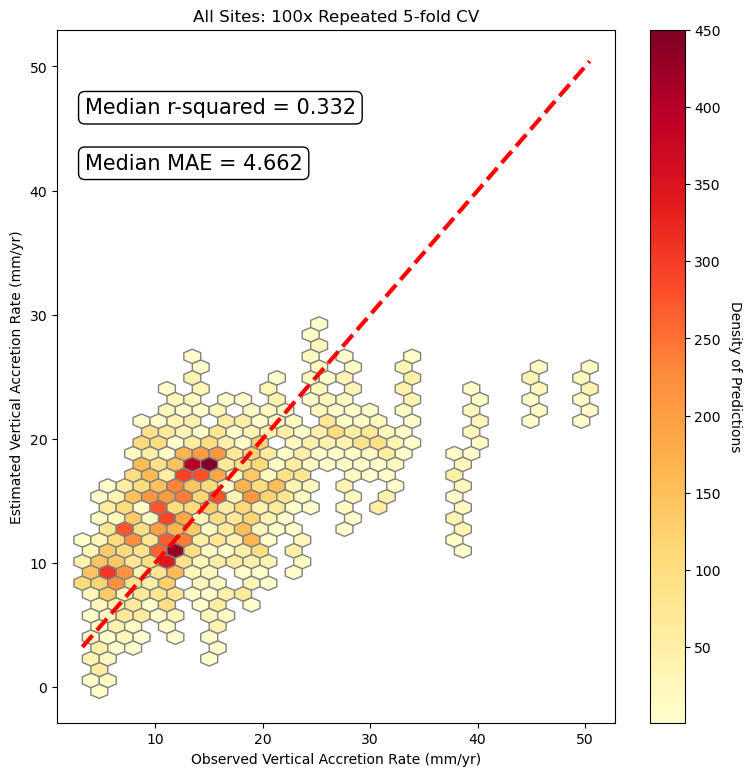

['Scaled Weights', 'Unscaled Weights', 'Unscaled Intercepts', 'Scaled regularizors', '# Well Determined Weights', 'Standard Deviations of Predictions', 'Predictions', 'Residuals', 'Predicted for Residuals']


In [17]:
def cv_results_and_plot(unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):

    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y
    residuals = []

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_weight_certainty = {}  # holds our estimate of the number of "well-determined" parameters
    hold_intercept = {}  # holds the intercepts found
    hold_prediction_certainty = {}  # holds the std deviations of the predictive distributions
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    intercept_ls = []  # holds the inverted intercept to its natural scale
    weight_certainty_ls = []  # holds the number of well-determinned parameters for each k-fold test
    prediction_certainty_ls = []  # holds the standard deviations of the predictions (predictive distributions)
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_certain = []
        pred_list = []
        w_certain = []

        for train_index, test_index in try_cv.split(X):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[bestfeatures],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

            intercept_ls.append(intercept)
            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))
            weight_certainty = []
            for eig in eigs[0]:
                weight_certainty.append(eig/(eig + baymod.lambda_))
            weight_certainty = np.sum(weight_certainty)
            w_certain.append(weight_certainty)
            # Make our predictions for y
            ypred, ystd = baymod.predict(X_test, return_std=True)
            # Save average std on each prediction
            # pred_certain.append(np.mean(ystd))

            pred_list += list(ypred)
            pred_certain += list(ystd)


            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_certainty_ls.append(pred_certain)
        prediction_list.append(pred_list)

        weight_certainty_ls.append(np.mean(w_certain))
        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
        residuals = residuals + list(target.values.ravel() - cross_val_predict(baymod, predictor_matrix, 
                                                                          target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=bestfeatures)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=bestfeatures)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)

    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Observed Vertical Accretion Rate (mm/yr)")
    ax.set_ylabel("Estimated Vertical Accretion Rate (mm/yr)")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, "Unscaled Weights": unscaled_weight_df, "Unscaled Intercepts": intercept_ls, 
        "Scaled regularizors": regularizor_ls, "# Well Determined Weights": weight_certainty_ls, 
        "Standard Deviations of Predictions": prediction_certainty_ls, "Predictions": prediction_list, 
        "Residuals": residuals, "Predicted for Residuals": predicted
    }


results_dict = cv_results_and_plot(phi, X, y, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(list(results_dict.keys()))

We see that we get a predictive accuracy of about ~30% R-squared and a mean absolute error of about ~4.6 millimeters (slight fluctuations will happen upon each run due to the randomness of the K-fold splitting). This is not an ideal model because it would be preferable to achieve higher predictive accuracies. However, note that our model consistently underpredicts for higher accretion rates. As depositional rates increase, the variability in accretion rates also increases which reduces the capability of our model to learn the proper relationship to approximate the data. So, a future investigation could be aimed at constraining which variables are associated with this variability and investigating what events influence the variabiloty in accretion rates.

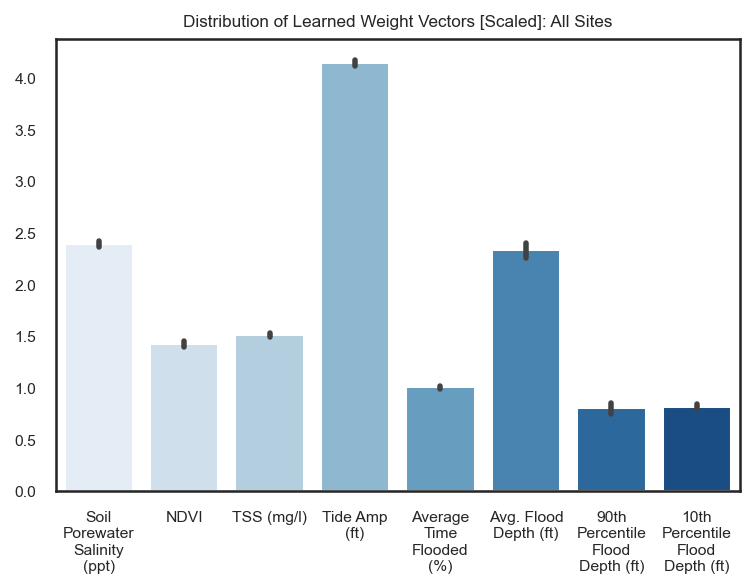

In [18]:
def wrap_labels(ax, width, break_long_words=False):
    """
    ax: plot axis object 
    width: width of textwrap
    break_long_words: boolean as to break long words in wrapping or not
    
    directly from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

The bar chart above indicates the relative feature importances of the identified variables. Of the identified salinet variables from the dataset related to accretion, we see that tidal amplitude is the most important variable contributing to accretion, while suspended sediment concetration is the least important variable contributing to accretion in the model. 

Something to consider here is the multicollinearity between the variables that is inherent to these environments. We must acknowledge this potential bias and keep it in mind for any future interpretations of the model. 

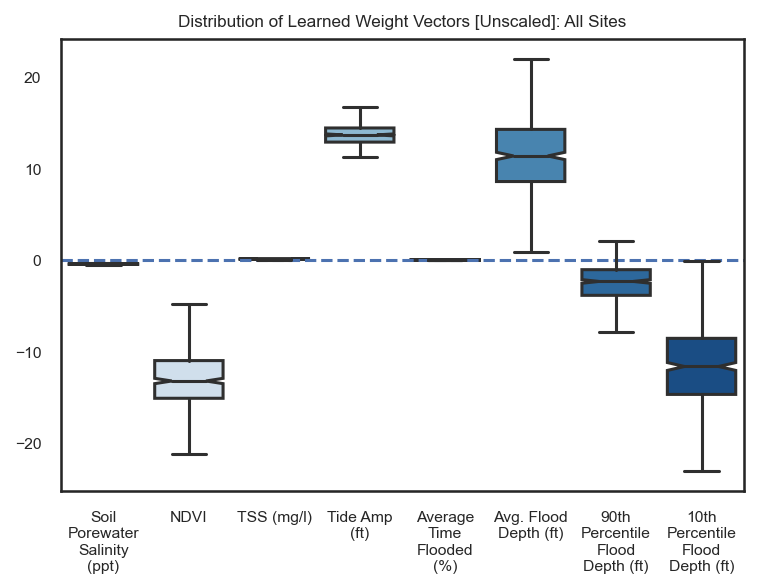

Soil Porewater Salinity (ppt)       -0.408256
NDVI                               -13.185922
TSS (mg/l)                           0.139868
Tide Amp (ft)                       13.713106
Average Time Flooded (%)             0.040570
Avg. Flood Depth (ft)               11.411379
90th Percentile Flood Depth (ft)    -2.304102
10th Percentile Flood Depth (ft)   -11.600975
dtype: float64

In [19]:
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict["Unscaled Weights"].median()

The above plot is now the unscaled weight coefficents. They are representaed through a boxplot because, since we run a 5-fold 100x repeated cross validation scheme, we train 500 models with slightly different learned weights because of splightly different splits of the data. Therefore, it is important to show the full range of the learned weights. We can intepret these as one would usually for any ordinarly least squares regression such that "a one unit increase in tidal amplitude results in a ~7.5 mm/yr increase in the accretion rate at a CRMS station."

## Gaussian Process Regression

Although linear models are great first order approximations, most of earth processes display nonlinear relationships. So, many times, a linear fit may be a silly approximation. So, let's try a nonlinear model that is a natural step forward from a Bayesian linear Regression: a Gaussian Process regression (GPR) model. We will also look towards the scikit learn package for implementing this model, although we will extract less information directly from the trained models as we did for the BLR and, rather, use a post hoc machine learning explainability package called "SHAP" to interpret how our model makes predictions with our variables.

Rather, then restarting the feature selection process from scratch, we will use the same identified variables as before. Again, we have to acknowledge the potential bias in these due to both multicollinearity and selection via the p-value which is meant for linear relationships, not nonlinear correlations. 

Similarly to the BLR, the conditional probability of the target variable is analytically solvable and has some fun math in its derivation. I will not go through the derivation in this tutorial because I want to focus more on the machine learning workflow side of things and its application to scientific discovery. However, a great explanation of the derivation is availible online here: https://towardsdatascience.com/gaussian-process-regression-from-first-principles-833f4aa5f842. Or in the *Pattern Recognition and Machine Learning* textbook by Christopher Bishop

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern

# Derived from https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
sigma_n = 1
kernel = (DotProduct() ** 2) + WhiteKernel()  # seemed to get 35%,

# GP model 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
# scores = cross_val_score(rs_model.best_estimator_, predictors, target.values.ravel(), scoring='r2',
#                          cv=rcv, n_jobs=-1)
scores = cross_validate(gp, X, y, cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median GP R^2 score", np.median(scores['test_r2']))
print("Median GP MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median GP R^2 score 0.42894957055702054
Median GP MAE score 4.250418083100124


## SHAP Analysis

In python, there is a handy package to explain how your model makes predictions post training. This is called "post-hoc" explainability by .... . The package is called SHAP and it is easy to install and use on a variety of different models. 

The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

I am only going to do a SHAP analysis on the Gaussian Process model because we have already assessed the relative feature importances of the Bayesian Ridge model through the scaled weight coefficents. However, there is no simple analogous interpretation of the parameters of the scikit learn Gaussian Process regression model. There, the SHAP post-hoc explainiability method must be employed to gain insight into how our model makes decisions.

<class 'pandas.core.frame.DataFrame'>


Exact explainer: 209it [00:13,  5.35it/s]                                       


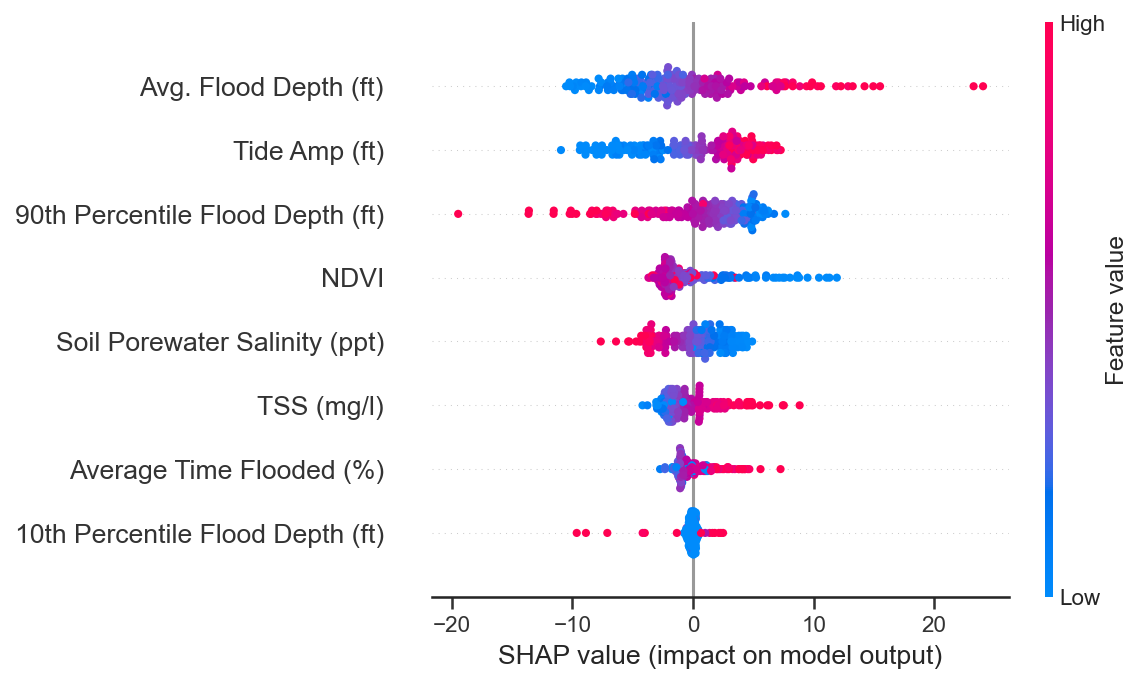

In [21]:
# fit the model first
gp.fit(X, y)
# Shap Analysis
X500 = shap.utils.sample(X, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(gp.predict, X500)  # explain a random sample of the data
shap_values_ebm = explainer_ebm(X)

# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.summary_plot(shap_values_ebm, features=X, feature_names=X.columns)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


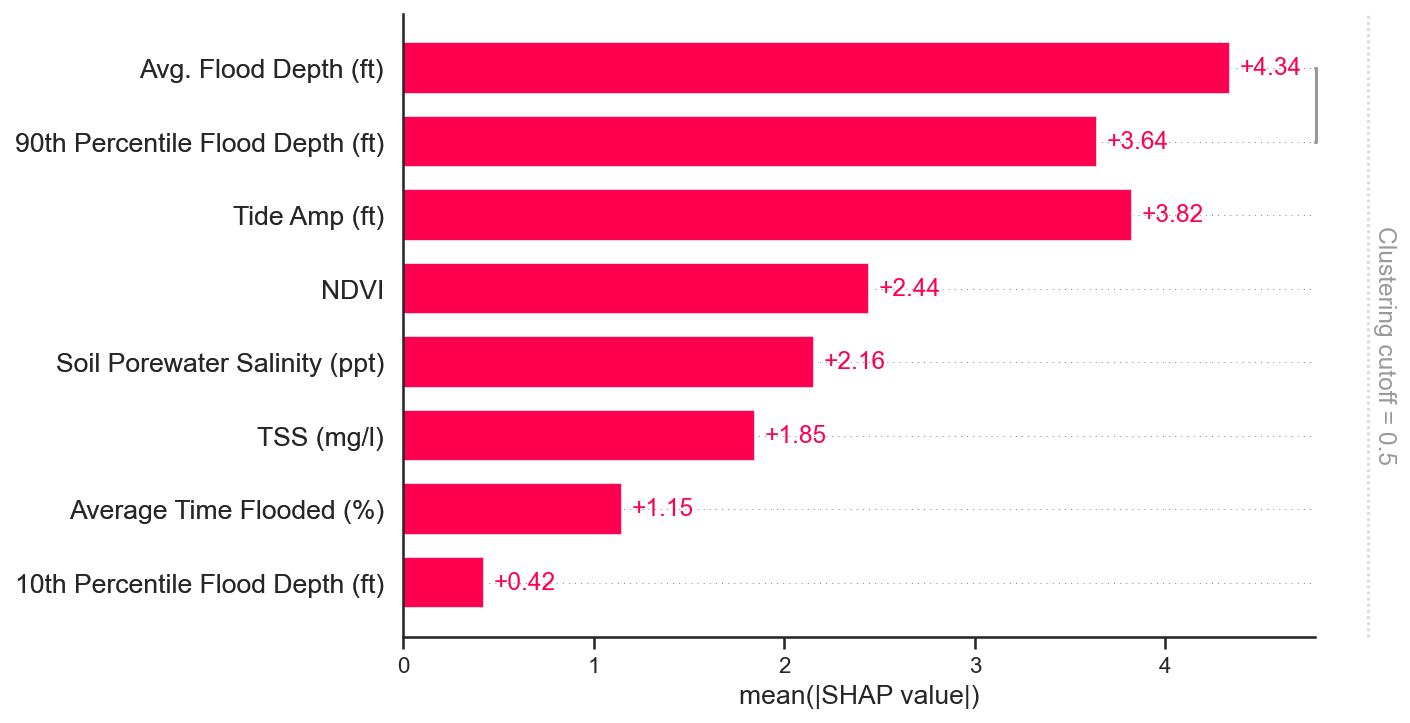

In [22]:
clustering = shap.utils.hclust(X, y)
shap.plots.bar(shap_values_ebm, clustering=clustering)

Something to note before proceeding is that these dependence plots show the influence of a certain variable from the GPR model on the SHAP value. The SHAP value is a proxy for how the model influences our target variable, accretion rate, therefore, I will be refering to an increase in the SHAP value as an increase in the expected accretion rate.

The summary beeswarm and clustering plots can give us a brief over view of some of the salient relationship within the GP model. For instance, average flood depth, tidal amplitude, TSS, and average percent time flooded all generally have positive influences on the predicted accretion rate. However, more of the samples in the average flood depth, TSS, and average percent time flooded variables have weakly negatively contribute to predicted accretion. We can discern this be the inspecting the size of the "beeswarm", or points, and whether they reside to the left or right of SHAP value = 0. On the other hand, the 90th percentile flood depth, soil porewater salinity, and NDVI generally have a negative relationship with estimated accretion rate. However, the majority of the data in the 90th percentile flood depth and salinity variables contributes weakly positively to expected accretion rate.

The combined importance and clustering plot indicates that there is a statistically significant relationship between the average flood depth and the 90th percentile flood depth, which is expected. Their relationship most then be taken into account when interpreting the relative importance of 90th percentile flood depth and average flood depth, as one of the variables may be redundant and its importance exaggerated. 

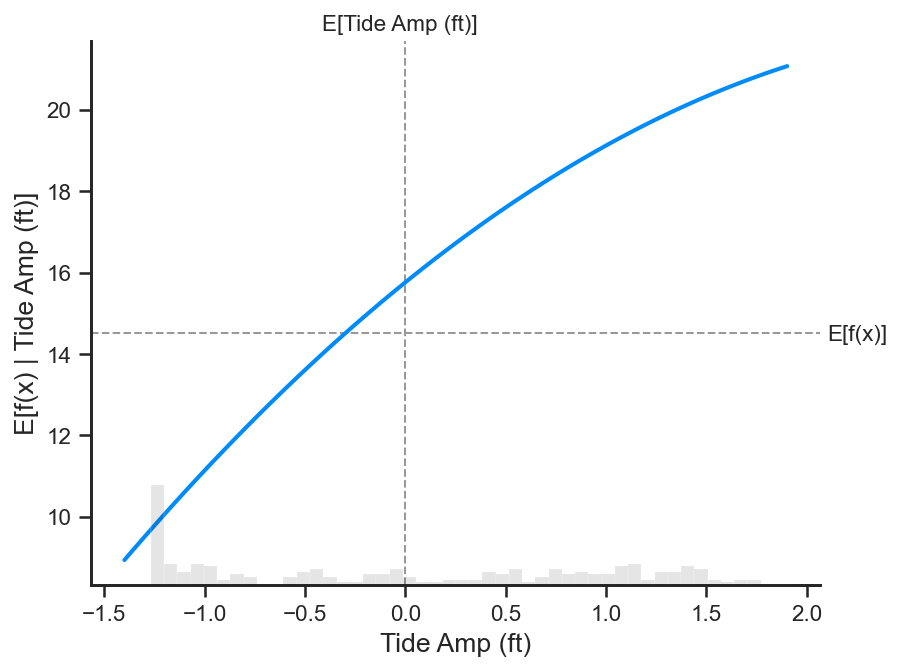

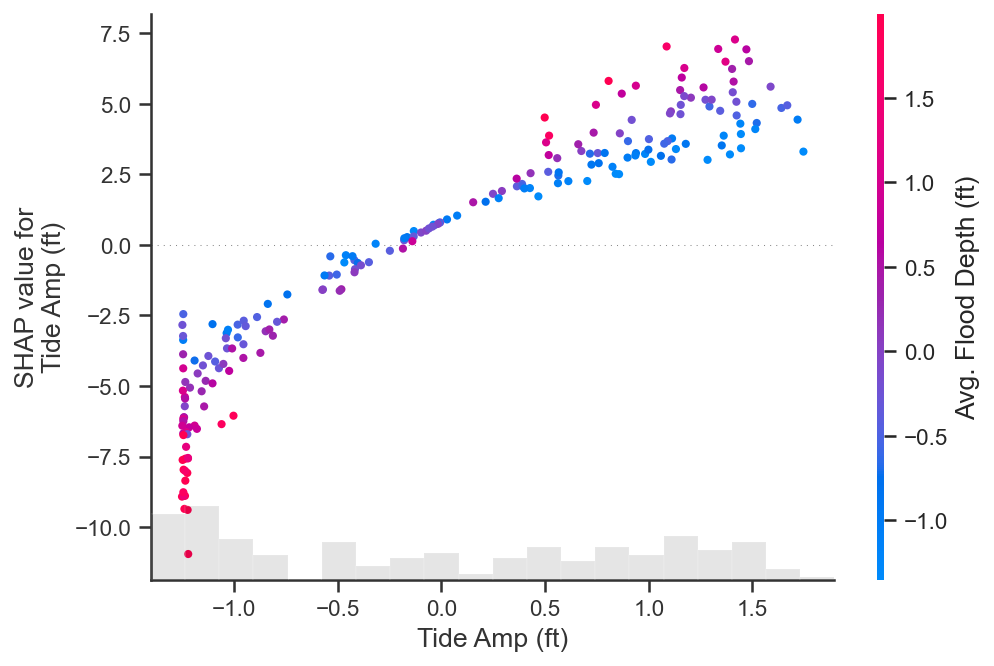

In [23]:
shap.partial_dependence_plot(
    'Tide Amp (ft)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Tide Amp (ft)"],
                   color=shap_values_ebm[:,"Avg. Flood Depth (ft)"])

The zero in the x-axis indicates that mean of the tidal amplitude data distriubtion, while each unit is s standard deviation. We notice that across the mean of the tidal amplitude data, flood depths have a opposite relationship with tidal amplitude and accretion rate. Where tidal amplitudes are below the mean, flood depth decreases with increasing tidal amplitude, while the expected accretion rate increases. Where tidal amplitudes are above the mean, flood depths increase with increasing tidal amplitude, while the expected accretion rate also increases.

The relationship here really highlights the dominance of the tidal amplitude, or the relative position of a CRMS station in the tidal frame, as a predictive variable for accretion rate. Additionally, with tidal amplitude increasing with flood depth above the mean tidal amplitude, we may expect this to be due to a greater influence of oceanic flood waters on flooding. To test qualitatively test this, we can look at the relationship between tidal amplitude, flood depth, and soil porewater salinity, assuming that an increase in the soil porewater salinity is associated with a more saline flooding regime.

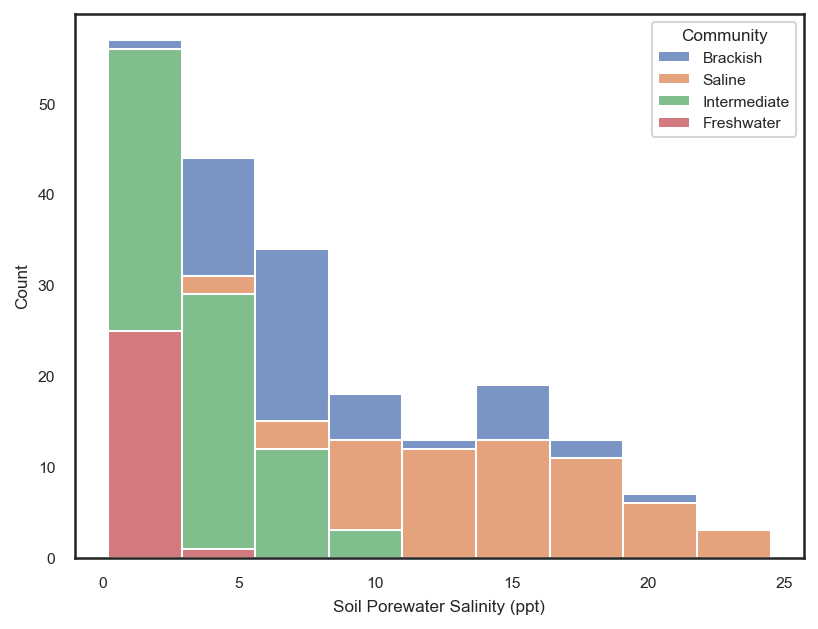

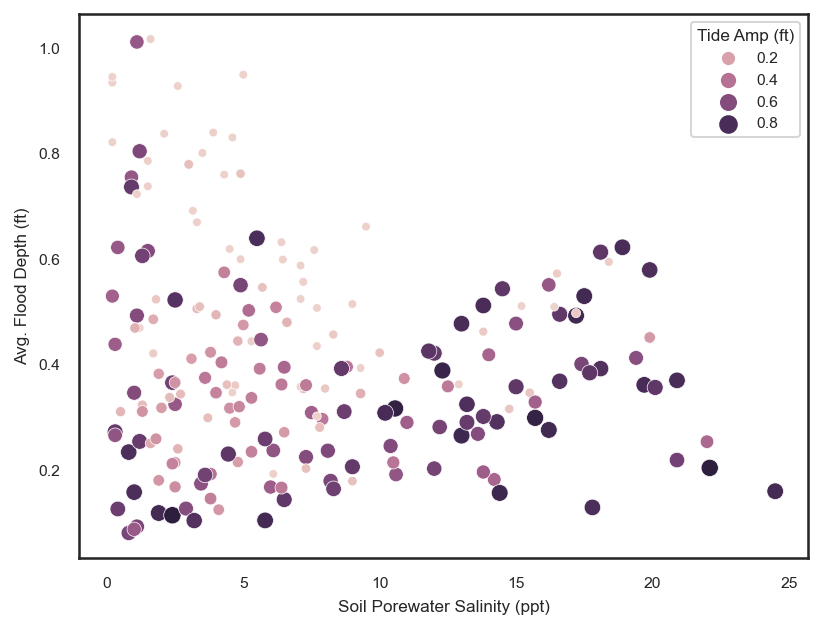

In [24]:
# Histogram to see splits in salinity distributions across marsh types
sns.histplot(data=df, x='Soil Porewater Salinity (ppt)', hue='Community', multiple='stack')
plt.show()
# scatter
sns.scatterplot(data=df, x='Soil Porewater Salinity (ppt)', y='Avg. Flood Depth (ft)', hue='Tide Amp (ft)',
               size='Tide Amp (ft)')
plt.show()

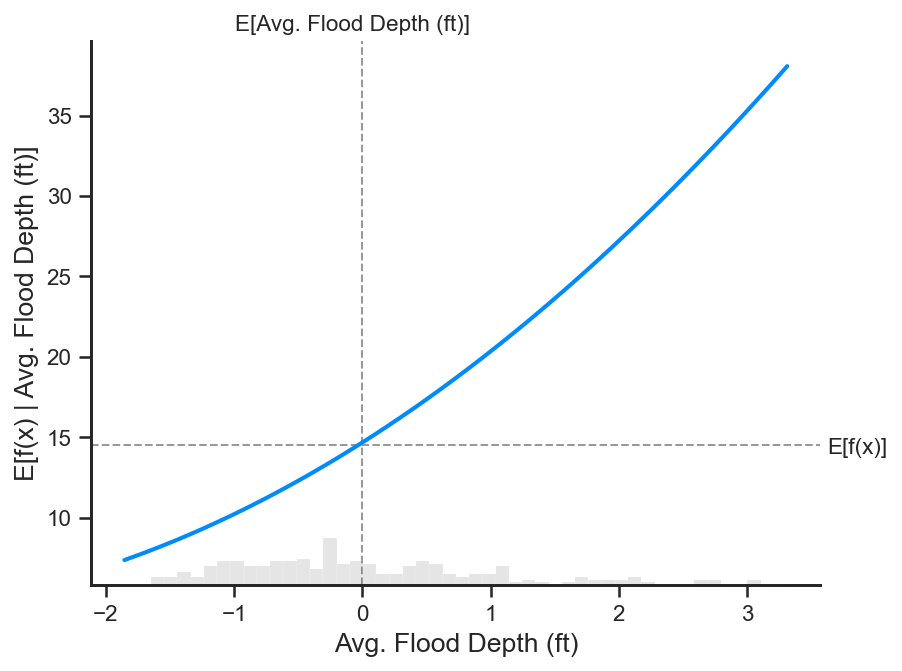

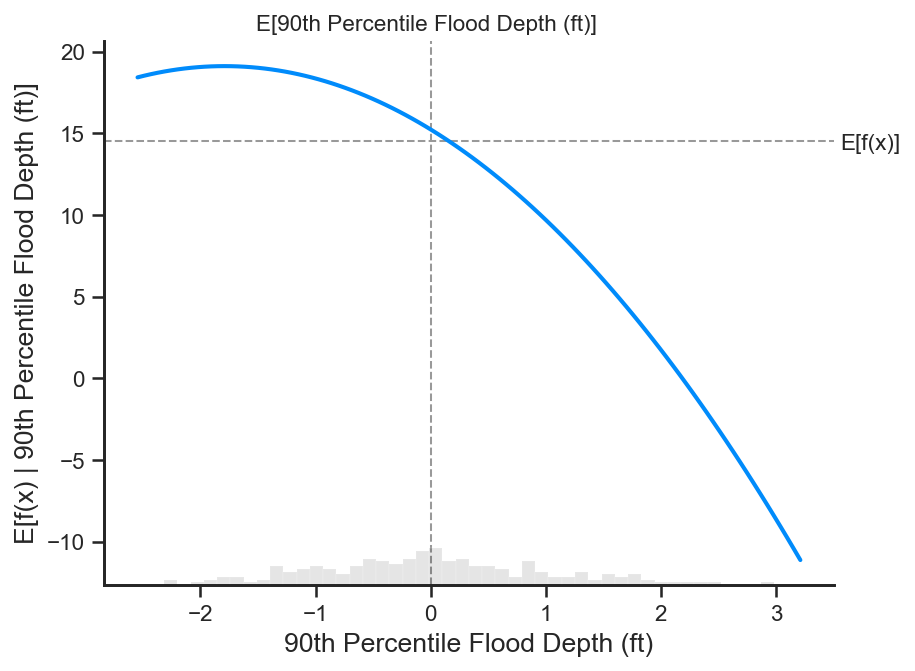

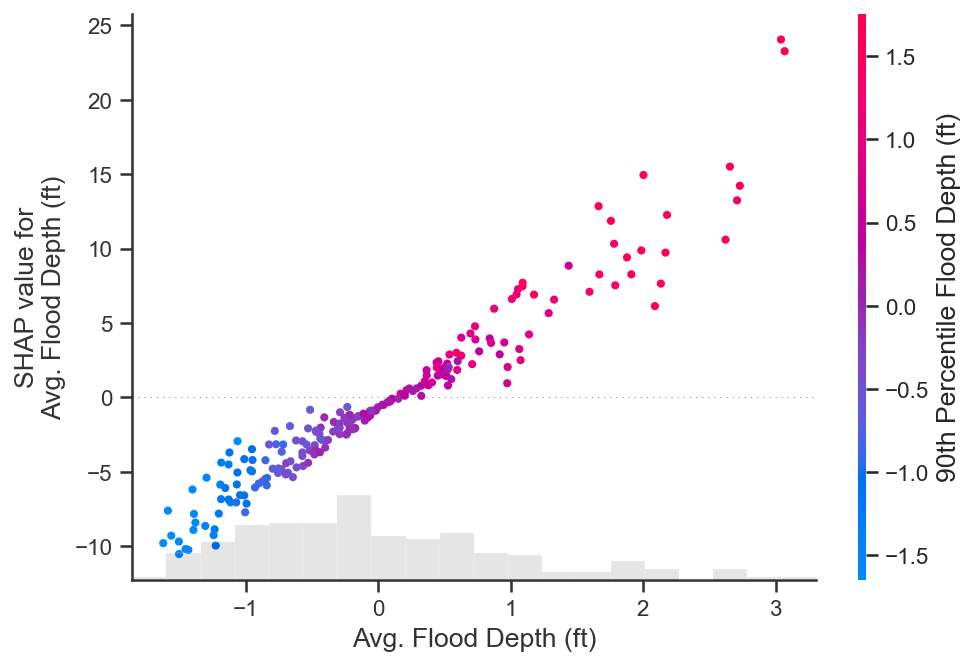

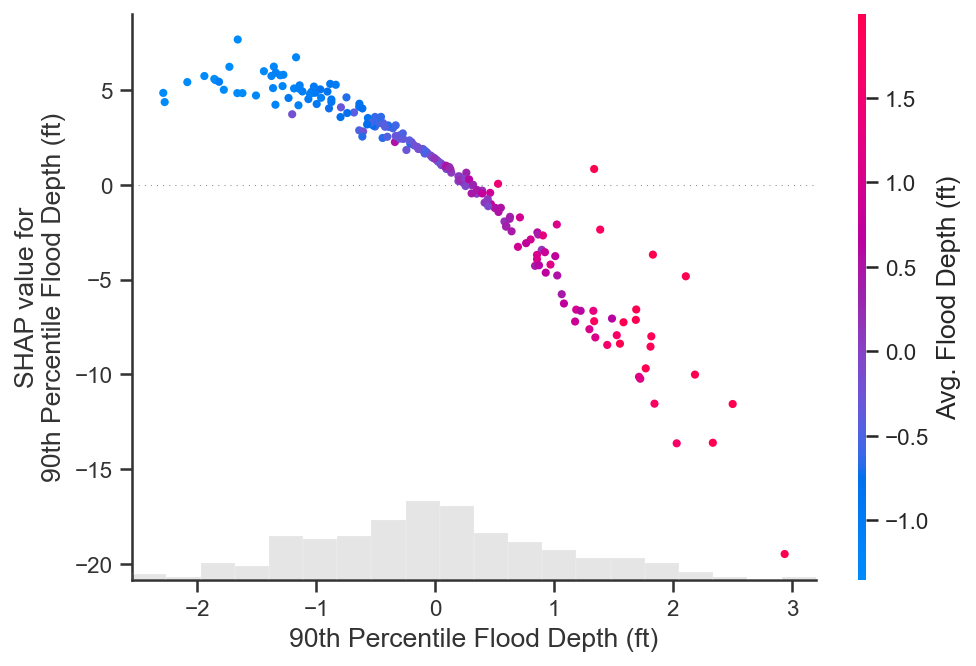

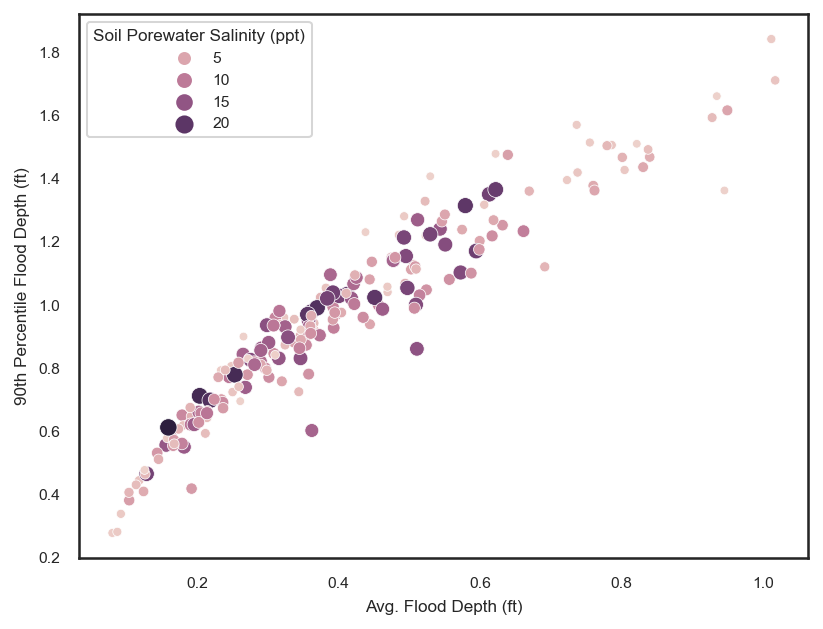

In [41]:
# partial dependence: the function
shap.partial_dependence_plot(
    'Avg. Flood Depth (ft)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# pd function for 90th percentile flood depth
shap.partial_dependence_plot(
    '90th Percentile Flood Depth (ft)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot of flood depth and 90th %
shap.plots.scatter(shap_values_ebm[:, "Avg. Flood Depth (ft)"], 
                   color=shap_values_ebm[:,"90th Percentile Flood Depth (ft)"])
# now the inverse plot
shap.plots.scatter(shap_values_ebm[:, "90th Percentile Flood Depth (ft)"], 
                   color=shap_values_ebm[:,"Avg. Flood Depth (ft)"])
# scatter plot
sns.scatterplot(data=df, x='Avg. Flood Depth (ft)', y='90th Percentile Flood Depth (ft)', 
                hue='Soil Porewater Salinity (ppt)', size='Soil Porewater Salinity (ppt)')
plt.show()

It is interesting that the 90th percent flooding depth displays a convex function, largely negative relationship, with expected accretion rate. However, as flood depth increases, so does the 90th Percentile of flood depth as expected. The interaction between these two variables indicates that our model uses the large end members of the floods that occur to provide a "check" on accretion rates, not allowing accretion rates to become excessive.

An interesting point to consider here is that the end members of the average flood depth versus 90th percentile flood depth relationship have the lowest salinity levels. Potentially this can be investigated further with additionally data to discern the influence of fluvial, fresh floods and oceanic, saline floods.

Now, we see that saline marshes dominant where soil porewater values are greater than 10 ppt, while the more freshwater marshes reside where salinity values are below 10 ppt. In the scatter plot, there is a positive relationship between salinity and average flood depth in saline marshes, where salinity exceeds 10 ppt. On the other hand, the relationship between salinity and flood depth is more obscure, to weakly logarithmic in the fresher marshes.

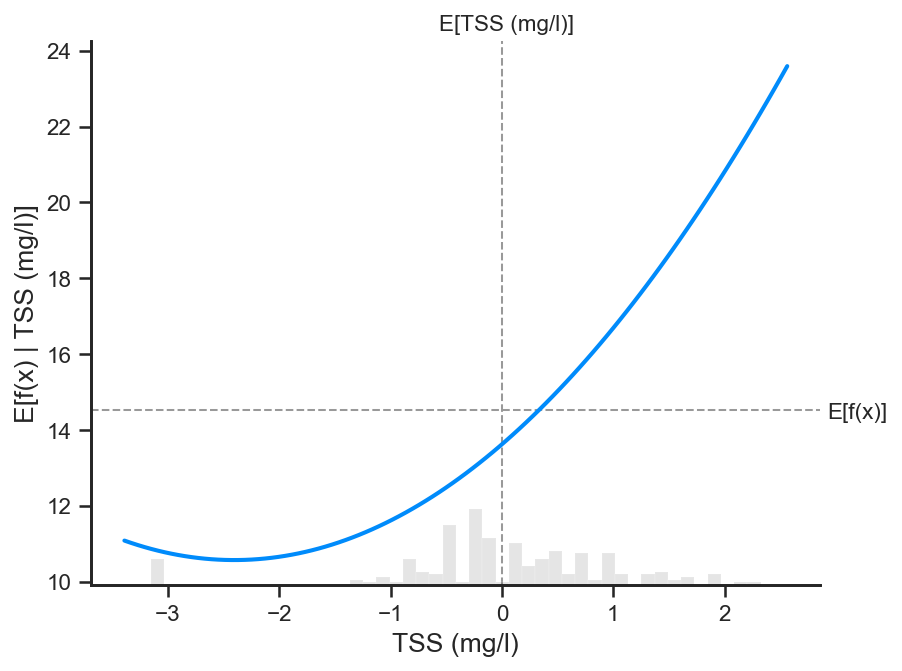

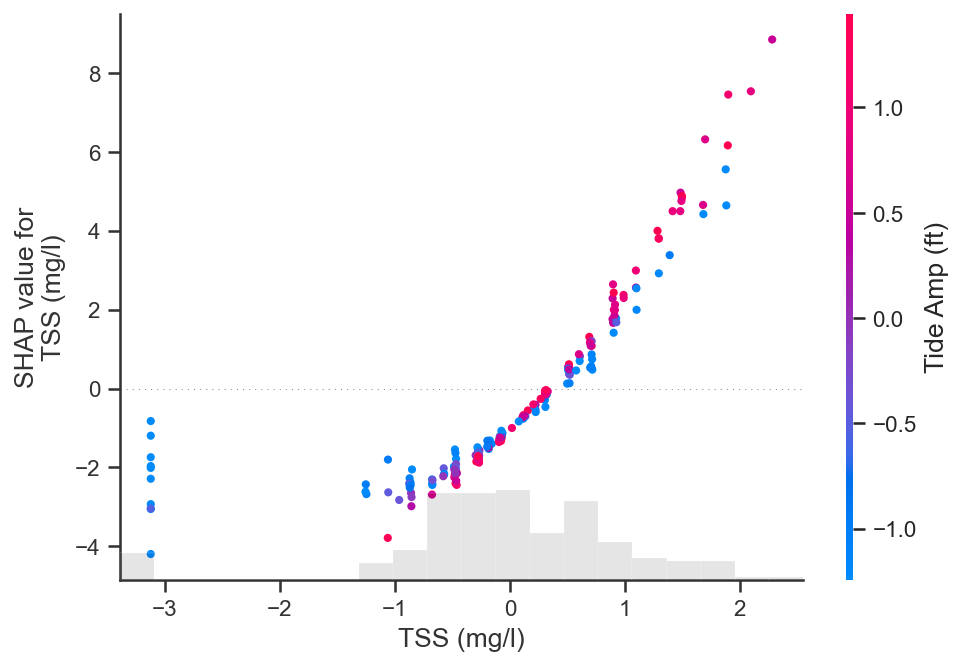

In [26]:
shap.partial_dependence_plot(
    'TSS (mg/l)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "TSS (mg/l)"],
                   color=shap_values_ebm[:,"Tide Amp (ft)"])

It can be seen that CRMS stations with both low and high tidal amplitudes have an increase in the predicted accretion rate as the estimated total suspended sediment concentration increases. If two an exponential function are fit to the total suspended sediment plot and shap value for samples with low and high tidal amplitudes, we would get similar exponential functions. 

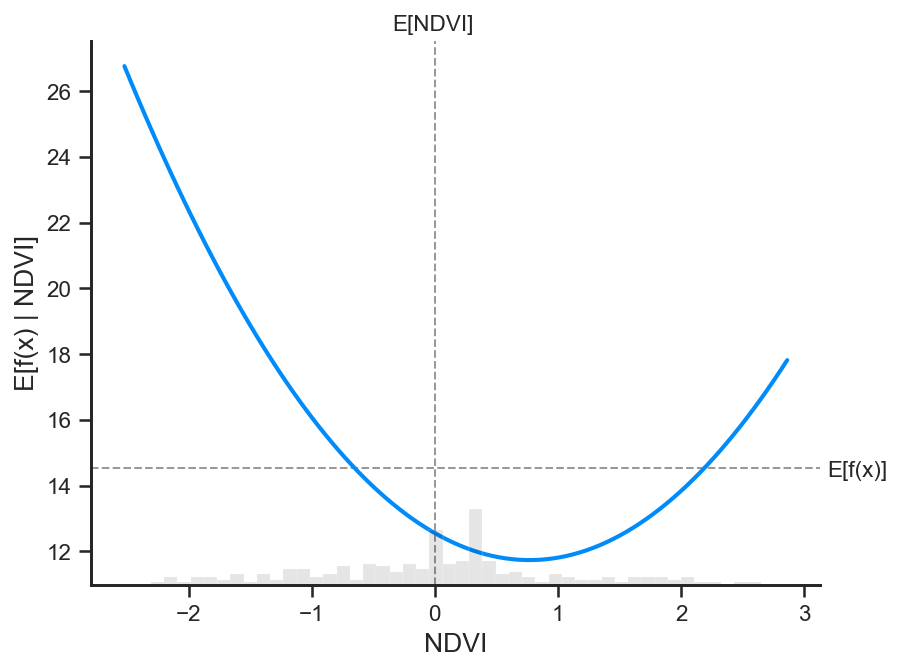

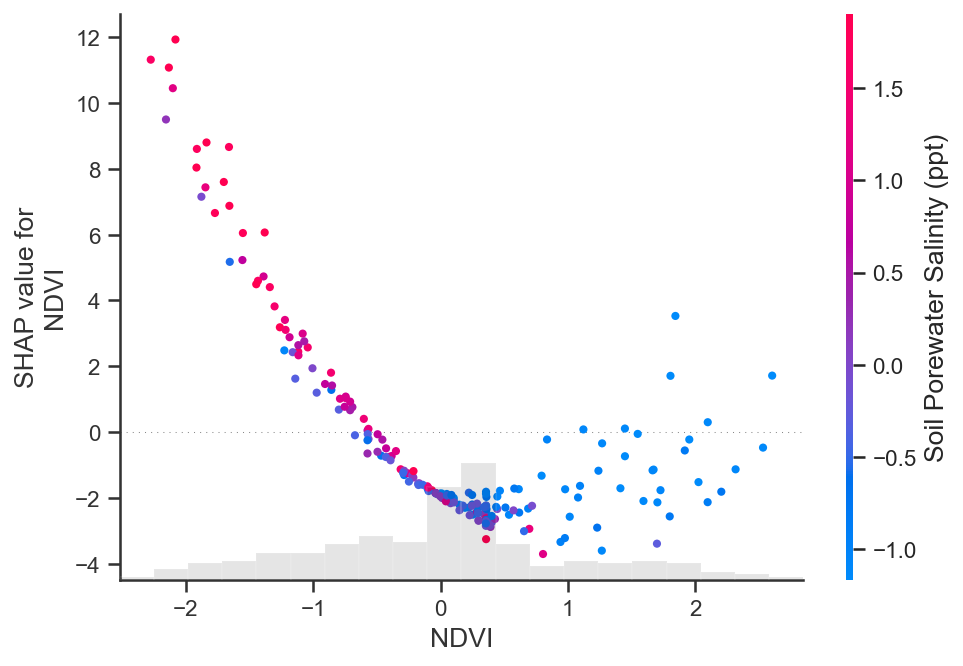

<AxesSubplot:xlabel='NDVI', ylabel='Accretion Rate (mm/yr)'>

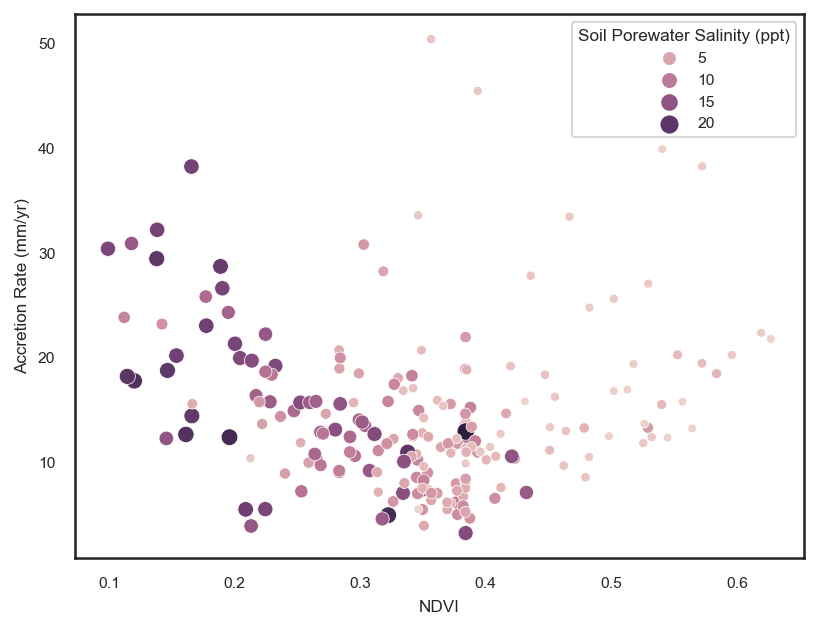

In [39]:
shap.partial_dependence_plot(
    'NDVI', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "NDVI"],
                   color=shap_values_ebm[:,"Soil Porewater Salinity (ppt)"])
# complementary scatter plot
sns.scatterplot(data=df, x='NDVI', y='Accretion Rate (mm/yr)', hue="Soil Porewater Salinity (ppt)", 
               size="Soil Porewater Salinity (ppt)")

The concave up function that NDVI has with the expected accretion rate is quite intriguing. Investigating the dependence with the the salinity variable indicates that higher salinities are associated with lower NDVI values, but higher expected accretion rates. While, higher NDVI values are assocaited with lower salinity and lower accretion rates. It is not immediately clear to me why this relationship exists, so let's visit a histogram and scatter plot below to try to disentangle these relationships.

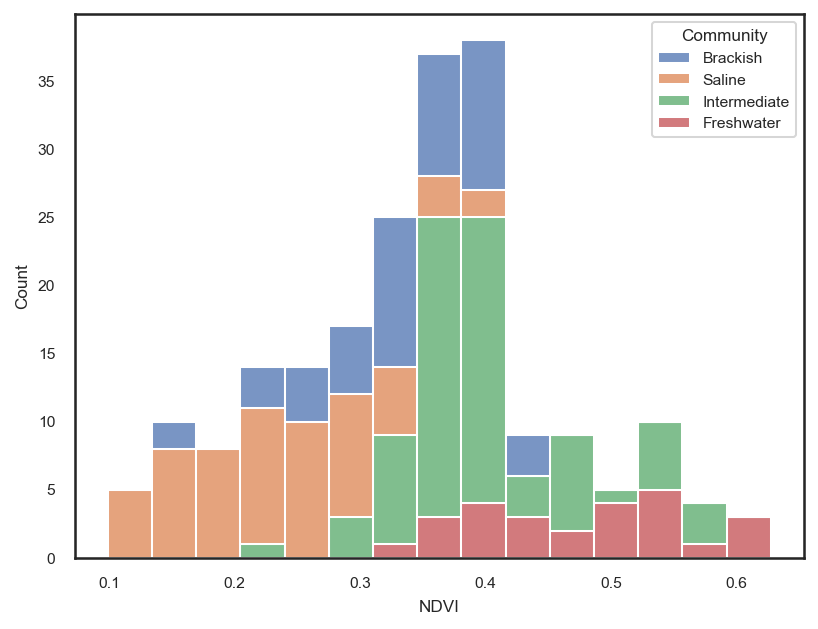

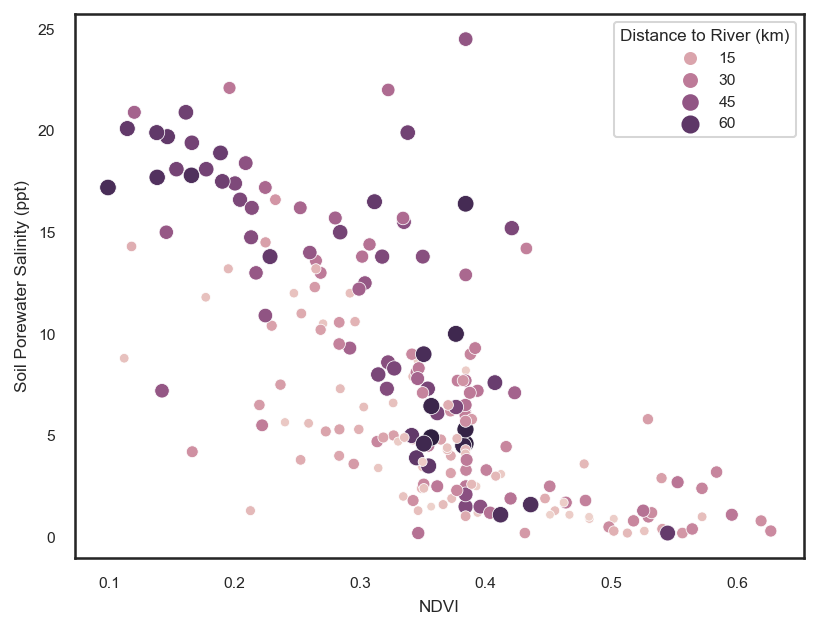

In [28]:
sns.histplot(data=df, x='NDVI', hue='Community',multiple='stack')
plt.show()
# # salinity , tides, and NDVI
# sns.scatterplot(data=df, 
#                 y='Soil Porewater Salinity (ppt)', hue='Tide Amp (ft)', size='Tide Amp (ft)',x='NDVI')
# plt.show()
# salinity, distance to river, and NDVI
df['Distance to River (km)'] = np.exp(df['Log Distance to River (km)'])
sns.scatterplot(data=df, 
                y='Soil Porewater Salinity (ppt)', hue='Distance to River (km)', size='Distance to River (km)', x='NDVI')
plt.show()

The above histogram indicates a split in the NDVI values between the more saline marshes and the more fresh marshes around an normalized NDVI value of ~0.35. To the left of the first scatter plot, more saline marshes, NDVI increases with decreasing salinity and decreasing distance from rivers. Across the freshwater and saline marsh transition, there is change in the relationship between NDVI, salinity, and distance from the river. Stations are now again far from the river, then decrease in salinity and increase in NDVI as they get closer. This makes some intuitive sense, but is fascinating that we can capture it!

The first scatter plot replaces the color and size variable with the distance to a major river (width > 30 m). As NDVI increases from 0 to its maximum value, we see the distance from the river variable decrease, increase, then decrease again. This increase occurs sharply at the saline and fresh water marsh NDVI transtion zone. First reading the left side of the scatter plot, NDVI < 0.35, we find that NDVI is greater for sites closer to major rivers. The same is true for the right side of the sactter plot, NDVI > 0.35, where NDVI increases closer to the major river with the exception of a few sites that may be located directly at the mouth of Mississippi River, which is often flooded near the ocean.

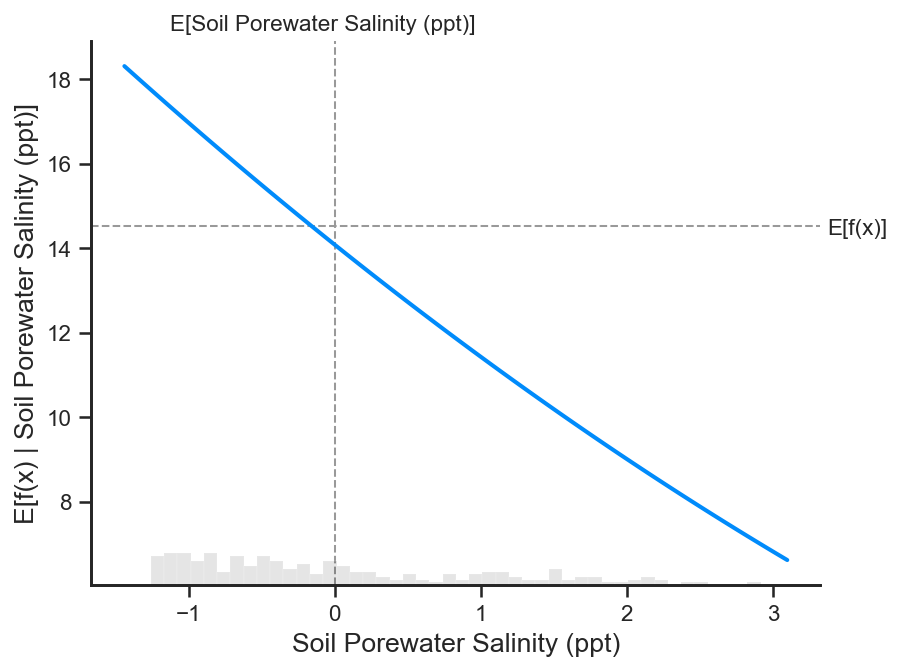

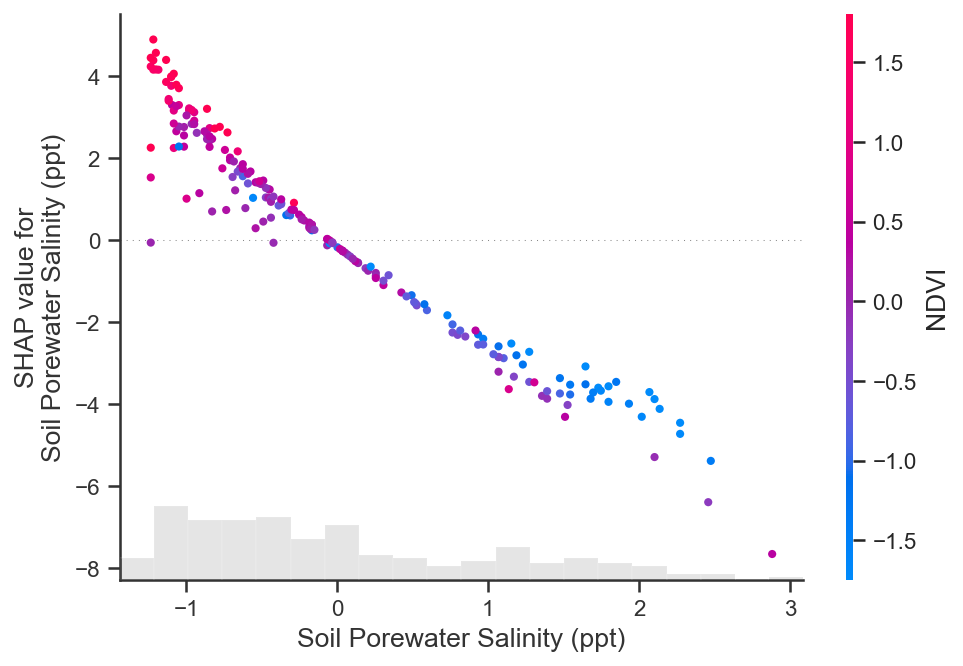

In [29]:
shap.partial_dependence_plot(
    'Soil Porewater Salinity (ppt)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Soil Porewater Salinity (ppt)"],
                   color=shap_values_ebm[:,"NDVI"])

The idea presented above between soil porewater salinity and NDVI is reinforced by visualizing the salinity dependence plot shaded by NDVI. Where salinity is high and NDVI is low, the expected accretion rate will be lower than when salinity is low and NDVI is high. 

Due to salinity being the 5th most important variable and NDVI being the 4th most important variable, this is potentially modeling the small organic inputs into measured marsh vertical accretion obtained through leaf litter capture from the aboveground biomass (proportional to NDVI) to the soil layer. However, before making any conclusions, there a few gaps in our knowledge about (1) how much much aboveground biomass is captured in the soil layer, (2) if NDVI is representative of belowground biomass, and (3) how much organic matter production contribute to accretion rates in each CRMS site. These gaps must be addressed before any assumptions can be made about the relationship displayed here.

## Conclusions

With the availibility of data online, computational resources, and emerging tutorials, using machine learning for scientific discovery has never been so attainable. Here I present only one of the many possible approaches to both model and interpret the complex dynamics of a natural system, a coastal wetland. Interpretable machine learning models that are grounded in analytical equations, such as BLR and GPR, are useful for better understanding model decisions. Both of the shown models work well for smaller datasets that are often found in many earth science fields that depend on field data. While these models do provide an avenue for forecasting, they also can be used for exploratory analysis. Given that the predictive accuracy of a machine learning model is sufficent, python packages such as SHAP can be used to attain a post-hoc explainablity of model predictions. Such investigations can be used to help derive physically informed models as well as environmental protection and management decisions. 